# Monitoring coastal erosion along Africa's coastline

* **Products used:**  
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr)  
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)  
[s1_rtc](https://explorer.digitalearth.africa/s1_rtc)

## Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.  

Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. 
Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

Imagery from satellites such as the NASA/USGS Landsat, Copernicus Sentinel-1/2 constellations is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale.

### DE Africa use case
The usefulness of optical imagery such as [Landsat](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_C2_SR_specs.html) and [Sentinel-2](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html) in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment), and the influence of tides. The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. mid-tide). These clean, tidally-constrained composite images can then be used to identify and extract the precise boundary between water and land. This allows us to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change. 

Radar observations are largely unaffected by cloud cover. By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline under all weather from the [Sentinel-1 analysis ready backscatter data](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-1_specs.html). Since radar measurement is sensitive to surface roughness, moisture content, and viewing geometry, the shoreline delineation can be affected by surface conditions such as breaking waves. Our temporal composite approach reduces noise caused by temporary conditions but shorelines mapped by radar may still be biased compared to shoreline identified in optical imagery. For example, smooth and flat beaches may be mistaken for water when they exhibit extremely low backscatter values.

### Description

In this example, we use a simplified version of the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) method to combine time series data with image compositing and tide filtering techniques to accurately map shorelines across time, and identify changes. For a selected area of interest, data from Landsat, Sentinel-2 or Sentinel-1 are selected based on availability. 

Following steps are demonstrated:
1. Query the satellite data and select best available product
2. Process the selected data and generate annual composite images for each year
3. Extract shorelines and calculate rates of coastal change

### Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
First we need to install additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository that will allow us to estimate rates of coastal change. 
> **Note:** If you run into any error messages in this analysis, try restarting the notebook by clicking `Kernel`, then `Restart Kernel and Clear All Outputs`.

In [1]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git@S2_test --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Now we can load key Python packages and supporting functions for the analysis.

In [2]:
%matplotlib inline

import os
import warnings

import datacube
import geopandas as gpd
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import seaborn as sns
from IPython.display import Image
from matplotlib.colors import ListedColormap
from odc.geo.geom import Geometry
from skimage.filters import threshold_minimum

warnings.filterwarnings("ignore")

from coastlines.raster import load_tidal_subset, tide_cutoffs
from coastlines.vector import annual_movements, calculate_regressions, points_on_line
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, load_best_available_ds, preprocess_s1
from deafrica_tools.plotting import display_map, rgb, xr_animation
from deafrica_tools.spatial import subpixel_contours
from eo_tides.eo import pixel_tides

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [3]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/33279/status,
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/33279/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33895,Workers: 1
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/33279/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:37595,Total threads: 4
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/41981/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:44397,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
dc = datacube.Datacube(app="Coastal_erosion_Landsat_Sentinel")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2018', '2021') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. `1Y` will generate one coastline for every year in the dataset; `2Y` will produce a coastline for every two years, etc.
* `filter_size`: An integer number defining the size of the speckle filter window used for Sentinel-1. As we will use temporal composites, which will help remove speckle noise, we recommend setting this filter size as None to disable speckle filtering, or a very small value (e.g. 2) to avoid significant degradation of spatial resolution.  
* `s1_orbit_filtering`: A boolean value defining whether to filter Sentinel-1 observations by satellite orbit. When this is set to True, a per-pixel filtering will be applied to keep only observations acquired in the orbit with higher frequency. This parameter is set to False by default, which means observations from both descending and ascending orbits will be returned.  

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Comoros. 

**To run the notebook for a different area**, make sure at least one of Landsat, Sentinel-2 or Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/).

To ensure that the tidal modelling part of this analysis works correctly, please make sure that **part of the study area is located over water** when setting `lat_range` and `lon_range`.


In [5]:
# Define the area of interest

# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-12.27, lon=43.726, buffer=0.01)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile.
# aoi = define_area(vector_path='aoi.shp')

# Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Set the range of dates for the analysis, time step and tide range
time_range = ("2018", "2023")
time_step = "1Y"

# Speckle filtering size for Sentinel-1 data
filter_size = 2

# whether to apply orbit filtering
s1_orbit_filtering = True

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
display_map(x=lon_range, y=lat_range)

## Query to find the best available product
The first step in this analysis is to select from the available satellite imagery products (Landsat, Sentinel-2, Sentinel-1 or merged Landsat and Sentinel-2) and load the best available one for shoreline mapping at the given location and study period.
Here we use the function `load_best_available_ds` to select and load the data. The function implements a few steps:
1. Query all three products using the `lat_range`, `lon_range` and `time_range` specified above and the `load_ard` function. The `load_ard` function will load and automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data. For more information see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).  
2. Calculate the average number and frequency of valid obseravations within each time period. Optionally the calculation can be restricted to a simplified coastal zone instead of the full image extent.   
3. Apply product selection rules using the calculated mean numbers and frequencies of valid observations, based on the decision tree as illustrated in the figure below. By default the required number and frequency of valid observations within each time period are 10 and 20% respectively, which can also be changed by setting the parameters `thresh_n_valid` and `thresh_freq`.  

![select_products.jpg](../Supplementary_data/Coastal_erosion/select_products.jpg)

The function takes in the `dc`, `lat_range`, `lon_range`, `time_range` and `time_step` as specified above. Other important optional parameters include:
* `combine_ls_s2`: A boolean value deciding whether to include merged Landsat and Sentinel-2 products as one of the products to choose from. By default it is set to False so that only Landsat, Sentinel-2 or Sentinel-1 will be used.
* `coastal_masking`: A boolean value deciding whether to calculate a simplified coastal zone mask and restrict the comparison of the products within the masked area. Enabling this option would likely exclude pixels outside coastal zone (e.g. inland or deep ocean) that are not critical for coastline mapping, but require more time (e.g. several minutes) to process. By default this parameter is set to False to accelerate data query and loading. 
* `set_resolution`: A pre-set spatial resolution (e.g. 20) in metres to query all products. By default this parameter is not set, so the original resolutions of the products will be used, i.e. 30 m for Landsat, 20 m for Sentinel-1 and 10 m for Sentinel-2.  
* `set_product`: Set this to only query and load a pre-selected product, i.e. 'ls' for Landsat,'s1' for Sentinel-1,'s2' for Sentinel-2, or 'ls_s2' for merged/stacked Landsat and Sentinel-2 data. By setting this parameter no other products will be queried or compared.  

Note: Depending on parameter setting, **the cell below may take more than 10 minutes to finish**. 

In [7]:
%%time
ds_selected, product_name = load_best_available_ds(
    dc, lat_range, lon_range, time_range, time_step, set_product="s2"
)

No resolution pre-set, using default resolutions for individual products...

Pre-selected product: Sentinel-2
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/opt/venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


Filtering to 637 out of 868 time steps with at least 20.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 637 time steps as a dask array


/opt/venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


CPU times: user 1min 32s, sys: 5.81 s, total: 1min 38s
Wall time: 16min 21s


The function above will print out some useful information on parameters setting, progress of the processing and why the product is chosen based on the selection rules. Using the default parameters set in this notebook, you will find that Sentinel-2 is chosen as the best available product by the above function, because it has the higher mean number and frequency of valid observations compared to Landsat across the scene and within each time step. Moreover, Sentinel-2 and Landsat are preferred over Sentinel-1 due to the occasional challenges in distinguishing between land and water in SAR backscatter images. Smooth and flat beaches, in particular, can exhibit extremely low backscatter values, making differentiation from water pixels difficult.

If the date range is set to start before 2017, only Landsat data will be queried and loaded due to limited availability of Sentinel data.

Once the load is complete, you can examine the product name and data by printing it in the next cell. The `Dimensions` argument reveals the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [8]:
print(product_name, "\n", ds_selected)

s2 
 <xarray.Dataset> Size: 466MB
Dimensions:      (time: 594, y: 223, x: 220)
Coordinates:
  * time         (time) datetime64[ns] 5kB 2018-01-17T07:22:03 ... 2023-12-30...
  * y            (y) float64 2kB -1.356e+06 -1.356e+06 ... -1.358e+06 -1.358e+06
  * x            (x) float64 2kB 3.603e+05 3.604e+05 ... 3.625e+05 3.625e+05
    spatial_ref  int32 4B 32638
Data variables:
    red          (time, y, x) float32 117MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    green        (time, y, x) float32 117MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    blue         (time, y, x) float32 117MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    swir_1       (time, y, x) float32 117MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
Attributes:
    crs:           epsg:32638
    grid_mapping:  spatial_ref


### Plot example timestamp
Here we can plot an example image at the selected location at a given timestamp. To visualise Landsat or Sentinel-2 data, use the pre-loaded `rgb` utility function to plot a true colour image for a given timestamp. White areas indicate where clouds or other invalid pixels in the image have been masked. If the selected product is Sentinel-1, we plot the vh band as an example.

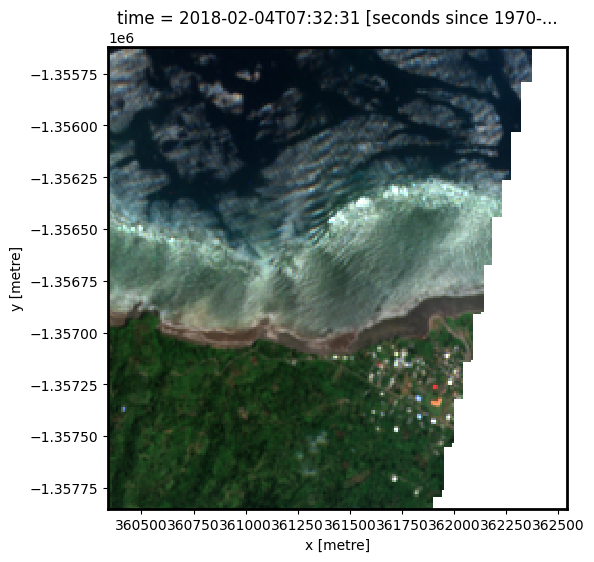

In [9]:
# Set the timesteps to visualise
timestamp = 4
if (product_name == "ls") or (product_name == "s2") or (product_name == "ls_s2"):
    # Generate RGB plots at each timestep
    rgb(ds_selected, index=timestamp, percentile_stretch=[0, 0.999])
else:
    ds_selected["vh"].isel(time=timestamp).plot.imshow(robust=True)


Change the value for `timestamp` and re-run the cell to plot a different timestamp (timestamps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timestamps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


## Process selected data and generate annual composites

### Model tide height  

For each satellite timestep, we use the `pixel_tides` function to model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the [FES2014 tidal model](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)), then reprojects modelled tides into the spatial extent of our satellite image. We add this new data as a new variable `tide_m` in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [10]:
ds_selected["tide_m"] = pixel_tides(
    data=ds_selected, model="FES2014", directory="/var/share/tide_models", resample=True
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original resolution


Based on the entire time-series of tide heights, we can compute the max and min satellite-observed tide height for each pixel, then calculate tide cutoffs used to restrict our data to satellite observations centred over mid-tide (0 m Above Mean Sea Level) using the tide_cutoffs function:

In [11]:
# Determine tide cutoff
tide_cutoff_min, tide_cutoff_max = tide_cutoffs(
    ds_selected, ds_selected["tide_m"], tide_centre=0.0
)

With the tide cutoffs calculated for all pixels, we now only keep observations within the tide height cutoff ranges. We also want to drop time-steps with no pixels within the cutoff ranges:

In [12]:
tide_bool = (ds_selected.tide_m >= tide_cutoff_min) & (
    ds_selected.tide_m <= tide_cutoff_max
)
ds_selected = ds_selected.sel(time=tide_bool.sum(dim=["x", "y"]) > 0)

# Apply mask, and load in corresponding tide masked data
ds_selected = ds_selected.where(tide_bool)
print(ds_selected)

<xarray.Dataset> Size: 302MB
Dimensions:      (time: 308, y: 223, x: 220)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2018-01-22T07:22:04 ... 2023-12-22...
  * y            (y) float64 2kB -1.356e+06 -1.356e+06 ... -1.358e+06 -1.358e+06
  * x            (x) float64 2kB 3.603e+05 3.604e+05 ... 3.625e+05 3.625e+05
    spatial_ref  int32 4B 32638
    tide_model   <U7 28B 'FES2014'
Data variables:
    red          (time, y, x) float32 60MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    green        (time, y, x) float32 60MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    blue         (time, y, x) float32 60MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    swir_1       (time, y, x) float32 60MB dask.array<chunksize=(1, 223, 220), meta=np.ndarray>
    tide_m       (time, y, x) float32 60MB -0.1599 -0.1599 ... 0.3183 0.3183
Attributes:
    crs:           epsg:32638
    grid_mapping:  spatial_ref


### Process selected data
To extract shoreline locations, we need to be able to separate water from land in our study area. 
To do this, for Landsat or Sentinel-2 we can calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and Shortwave-Infrared (SWIR) radiation to identify the presence of water [(Xu 2006)](https://doi.org/10.1080/01431160600589179). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{SWIR})}{(\text{Green} + \text{SWIR})}
\end{aligned}
$$

where `Green` is the green band and `SWIR` is the SWIR band. 

For Sentinel-1 data, we have implemented a few optional pre-processing steps. As radar observations appear speckly due to random interference of coherent signals from target scatters, we implemented speckle filtering using Lee filter, which is one of the popular adaptive speckle filters that takes into account local homogeneity. 

Besides, each of the Sentinel-1 observations were acquired from either a descending or ascending orbit. The orbital direction impacts on the local incidence angle and backscatter value. Therefore, we implemented a per-pixel filtering to keep only observations from the dominant orbit, which is expected to minimise the effects of inconsistent looking angle and obit direction for each individual pixel. In addition, it is often useful to convert the backscatter to decible (dB) for analysis. Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

These preprocessing steps are applied using function `preprocess_s1` and the parameter `filter_size` and `s1_orbit_filtering` as specified at the begining of the notebook. Note that Sentinel-1 preprocessing may take a few minutes to finish.

In [13]:
if product_name == "ls":
    # Calculate the water index
    ds_selected = calculate_indices(ds_selected, index="MNDWI", satellite_mission="ls")
elif (product_name == "s2") or (product_name == "ls_s2"):
    # Calculate the water index
    ds_selected = calculate_indices(ds_selected, index="MNDWI", satellite_mission="s2")
else:
    ds_selected = preprocess_s1(
        ds_selected, filter_size=filter_size, s1_orbit_filtering=s1_orbit_filtering
    )

### Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, e.g. cloud/cloud shadow for optical images and effects of wind on the water for radar images. To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '1Y'`, the code will produce one new image for each year in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

When it comes to interpreting the index, **high values (blue colours) typically represent water pixels**, while **low values (red colours) represent land**. 

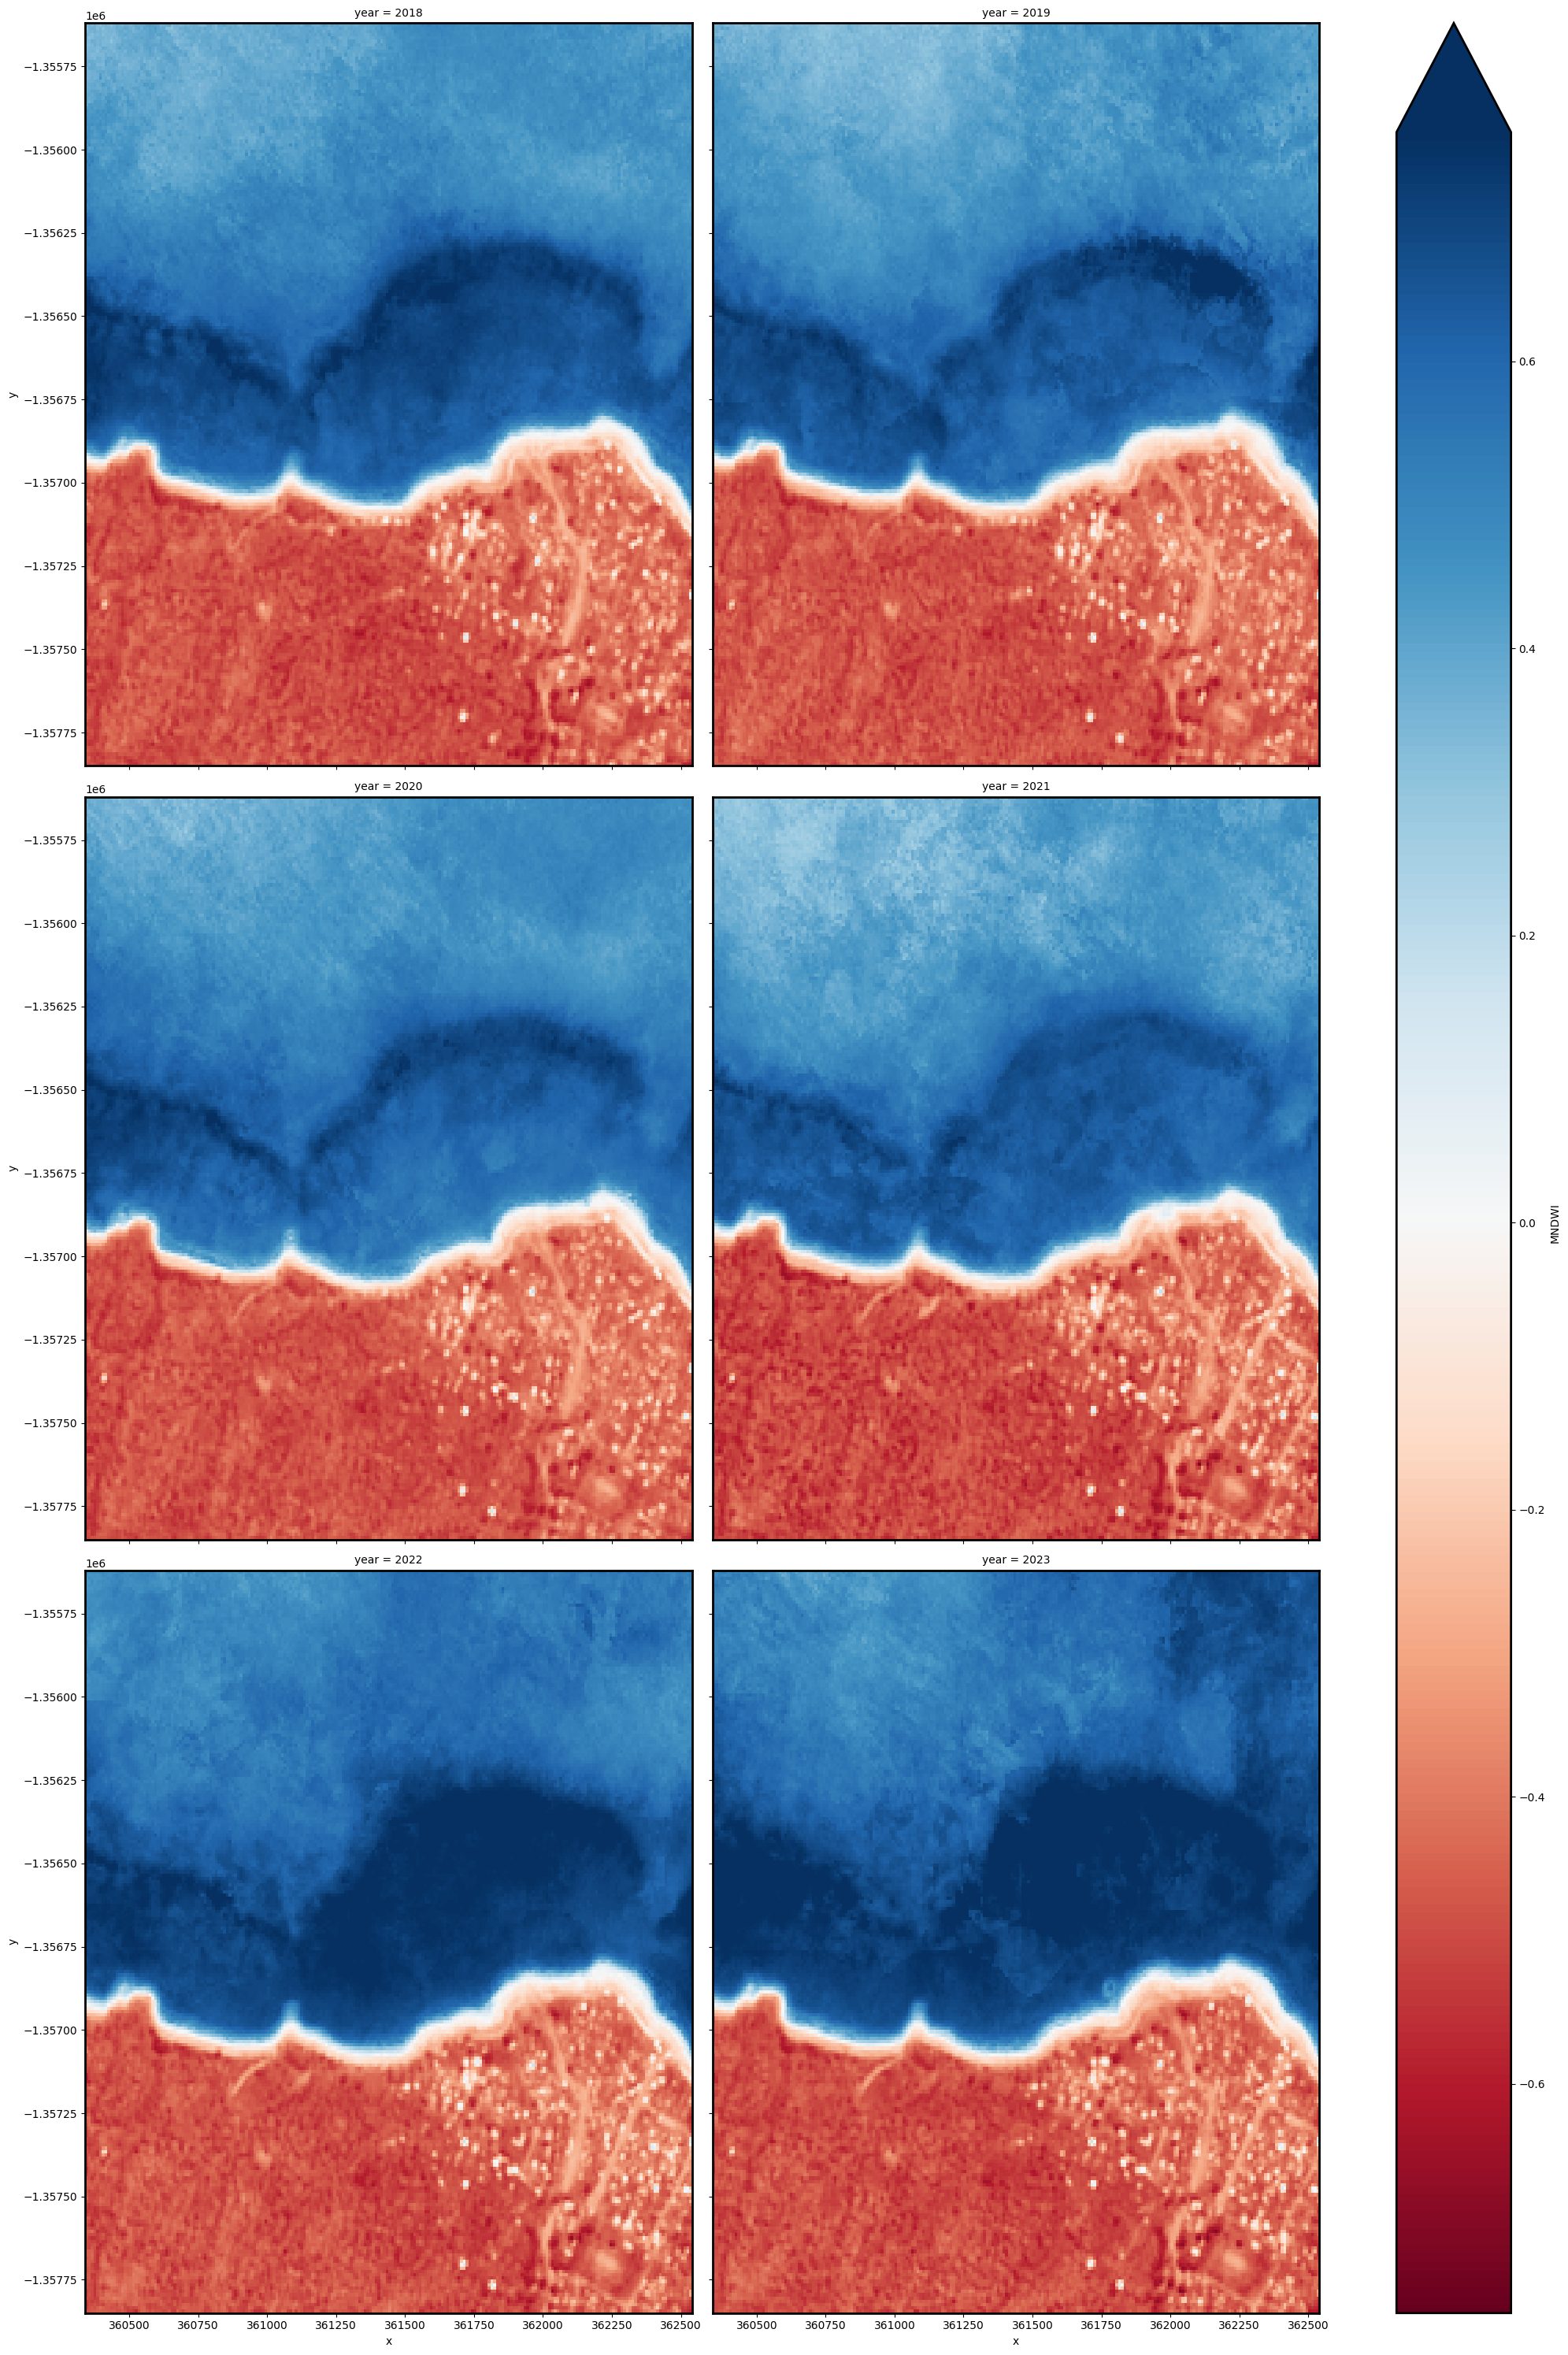

In [14]:
# Combine into summary images by `time_step`
if (product_name == "ls") or (product_name == "s2") or (product_name == "ls_s2"):
    var = "MNDWI"
else:
    var = "vh"

ds_summaries = ds_selected[[var]].resample(time=time_step).median("time").compute()
# Rename time attribute as year
ds_summaries["time"] = ds_summaries.time.dt.year
ds_summaries = ds_summaries.rename(time="year")

# Plot the output summary images
ds_summaries[var].plot(col="year", cmap="RdBu", col_wrap=2, robust=True, size=10)
plt.show()

In [15]:
# Shut down Dask client now that we have processed the data we need
client.close()

## Extract shorelines and calculate rates of coastal change 
### Extract shorelines from imagery
We now want to extract an accurate shoreline for each of the summary images above. The code below identifies the boundary between land and water by tracing a line along pixels with a given threshold value. For Landsat and Sentinel-2 images, we use a water index value of `0`. 

For Sentinel-1 images, the threshold could be determined either through simple automatic thresholding, or using a more complicated supervised classification method. In this notebook we use the `threshold_minimum` function, which computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold. 

We use the `subpixel_contours` function to identify the boundary between land and water by tracing a line along pixels with the previously identified threshold value. It returns a vector file with one line for each time step:


In [16]:
if (product_name == "ls") or (product_name == "s2") or (product_name == "ls_s2"):
    threshold = 0
else:
    threshold = threshold_minimum(
        ds_selected[var].values[~np.isnan(ds_selected[var].values)]
    )

contour_gdf = subpixel_contours(
    da=ds_summaries[var],
    z_values=threshold,
    dim="year",
    crs=ds_summaries.geobox.crs,
    output_path="annual_shorelines_{}.geojson".format(product_name),
    min_vertices=15,
)
contour_gdf = contour_gdf.set_index("year")
# Preview shoreline data
contour_gdf

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_s2.geojson


,geometry
year,
2018,"MULTILINESTRING ((362535 -1357104.58, 362526.4..."
2019,"MULTILINESTRING ((362535 -1357091.499, 362528...."
2020,"MULTILINESTRING ((362535 -1357110.435, 362530...."
2021,"MULTILINESTRING ((362535 -1357081.076, 362528...."
2022,"MULTILINESTRING ((362535 -1357102.476, 362531...."
2023,"MULTILINESTRING ((362535 -1357089.159, 362531...."


### Plot resampled shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [17]:
# Plot shorelines on interactive map
bounds = np.arange(2018, 2022, 1)

contour_gdf.reset_index().explore(
    column="year",
    cmap="inferno",
    categorical=True,
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI WorldImagery",
)

### Calculate rates of coastal change
To identify parts of the coastline that are changing rapidly, we can use our annual shoreline data to calculate rates of coastal change in metres per year.
This can be particularly useful to reveal hotspots of coastal retreat (e.g. erosion), or hotspots of coastal growth.

To do this, we first need to create a set of evenly spaced points at every 20 metres along the most recent shoreline in our dataset. 
These points will be used to plot rates of coastal change across our study area.

<Axes: >

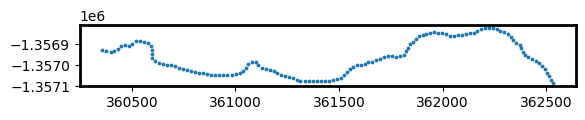

In [18]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index=2023, distance=20)
points_gdf.plot(markersize=3)

Now that we have a set of modelling points, we can measure distances from each of the points to each annual shoreline. 
This gives us a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of our points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because our points were created along our most recent 2023 shoreline, distances for 2023 will always have a distance of 0 m.

In [19]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2023 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(
    points_gdf,
    contours_gdf=contour_gdf,
    yearly_ds=ds_summaries,
    baseline_year=2023,
    water_index=var,
)
points_gdf

,geometry,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,dist_2023,angle_mean,angle_std
0,POINT (362535 -1357089.159),-10.29,-1.60,-11.76,8.08,-5.76,0.0,38,27
1,POINT (362524.022 -1357072.536),-12.22,-6.26,-10.22,3.72,-6.28,0.0,53,24
2,POINT (362515.427 -1357054.774),-14.54,-8.95,-12.83,0.61,-6.04,0.0,54,23
3,POINT (362505.424 -1357037.87),-14.63,-9.45,-11.72,-1.05,-6.04,0.0,52,21
4,POINT (362494.492 -1357021.25),-14.92,-8.60,-12.74,1.46,-7.77,0.0,53,23
...,...,...,...,...,...,...,...,...,...
124,POINT (360430.432 -1356920.401),-3.05,-2.18,-2.32,1.53,-1.89,0.0,158,12
125,POINT (360415.676 -1356933.771),0.19,0.26,1.88,0.80,-1.45,0.0,146,17
126,POINT (360396.536 -1356936.727),-1.62,0.86,-0.63,0.84,-1.45,0.0,3,2
127,POINT (360377.006 -1356932.488),-3.39,-2.18,-5.01,-0.72,-1.88,0.0,4,9


Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [20]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf, contours_gdf=contour_gdf)
points_gdf

,rate_time,sig_time,se_time,outl_time,dist_2018,dist_2019,dist_2020,dist_2021,dist_2022,dist_2023,angle_mean,angle_std,geometry
0,1.680,0.397,1.773,,-10.29,-1.60,-11.76,8.08,-5.76,0.0,38,27,POINT (362535 -1357089.159)
1,2.142,0.152,1.213,,-12.22,-6.26,-10.22,3.72,-6.28,0.0,53,24,POINT (362524.022 -1357072.536)
2,2.711,0.058,1.027,,-14.54,-8.95,-12.83,0.61,-6.04,0.0,54,23,POINT (362515.427 -1357054.774)
3,2.687,0.029,0.805,,-14.63,-9.45,-11.72,-1.05,-6.04,0.0,52,21,POINT (362505.424 -1357037.87)
4,2.608,0.095,1.197,,-14.92,-8.60,-12.74,1.46,-7.77,0.0,53,23,POINT (362494.492 -1357021.25)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.571,0.191,0.363,,-3.05,-2.18,-2.32,1.53,-1.89,0.0,158,12,POINT (360430.432 -1356920.401)
125,-0.205,0.494,0.272,,0.19,0.26,1.88,0.80,-1.45,0.0,146,17,POINT (360415.676 -1356933.771)
126,0.075,0.806,0.288,,-1.62,0.86,-0.63,0.84,-1.45,0.0,3,2,POINT (360396.536 -1356936.727)
127,0.633,0.160,0.367,,-3.39,-2.18,-5.01,-0.72,-1.88,0.0,4,9,POINT (360377.006 -1356932.488)


### Plot rates of coastal change on an interactive map
Now that we have calculated rates of coastal change, we can plot these on an interactive map to identify parts of the coastline that are retreating or growing over time.

When the map appears below, hover your mouse over the coloured dots that appear along the coastline for a summary of recent coastal change at those locations. 
Red dots represent locations that are retreating (e.g. erosion), and blue dots represent locations that are growing.

![coastal_change.jpg](../Supplementary_data/Coastal_erosion/coastal_change.jpg)

In [21]:
# Add human-friendly label for plotting
points_gdf["Coastal change"] = points_gdf.apply(
    lambda x: f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f"by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since "
    f"<b>{contour_gdf.index[0]}</b></h4>",
    axis=1,
)
points_gdf.loc[points_gdf.sig_time > 0.05, "Coastal change"] = (
    f"<h4>No significant trend of retreat or growth)</h4>"
)

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column="year",
    cmap="inferno",
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tooltip=False,
    style_kwds={"opacity": 0.5},
    attr="ESRI WorldImagery",
    categorical=True,
)

# Add rates of change to map
points_gdf.explore(
    m=m, column="rate_time", vmin=-5, vmax=5, tooltip="Coastal change", cmap="RdBu"
)

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, we can export our output rates of change file so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [22]:
points_gdf.to_crs("EPSG:4326").to_file(
    "rates_of_changes_{}.geojson".format(product_name)
)

## Plot annual shorelines animated GIF

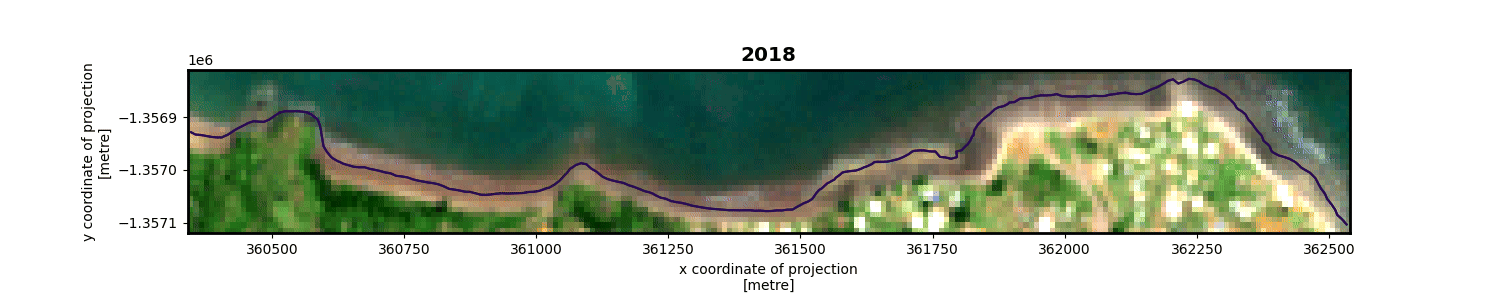

In [23]:
gdf = gpd.GeoDataFrame(
    data=contour_gdf.reset_index(), geometry=contour_gdf.reset_index().geometry
)
gdf_year = gdf.year.values

# Extract annual RGB noise-free summary images
ds_rgb = (
    ds_selected[["red", "green", "blue"]]
    .resample(time=time_step)
    .median("time")
    .compute()
)
extent = gdf.total_bounds
ds_rgb = ds_rgb.rio.clip_box(*extent)


fig, ax = plt.subplots(figsize=(15, 3))

# Generating the color scheme based on the number of years
lenyear = len(gdf_year)
palette = list((sns.color_palette("inferno", lenyear).as_hex()))
wsf = []
color = []
color_index = 0

for i in range(0, len(gdf_year)):
    year_list = gdf_year[i]
    color.append(palette[color_index])
    color_index += 1


def update(i):
    cs_plt = gdf.where(gdf.year == gdf_year[i]).plot(
        cmap=ListedColormap(palette[i]), ax=ax
    )
    t = ax.set_title(gdf_year[i], size="x-large", weight="bold")
    return cs_plt


rgb(ds_rgb, index=1, ax=ax)
ani = animation.FuncAnimation(fig, update, len(gdf_year - 1), interval=1000)
ani.save("coastline.gif")
plt.close()

Image(filename="coastline.gif")

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `time_step` or `lat`/`lon`) and rerun the analysis.
If you're going to change the location, you'll need to make sure at least one of Landsat, Sentinel-2 and Sentinel-1 products is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/). 

For more information about the method behind this notebook, read the scientific paper:
> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [24]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [25]:
from datetime import datetime

datetime.today().strftime("%Y-%m-%d")

'2025-07-29'